In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = (114, 114, 3)

In [ ]:
# remove images from folder that are not faces
def delete_files_without_keyword(folder_path, keyword):
    for filename in os.listdir(folder_path):
        if keyword not in filename:
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path):
                os.remove(file_path)
                print(f"Deleted: {filename}")


In [64]:
# open the csv with filenames and real_age
def open_csv(path):
    df = pd.read_csv(path)
    df = df.drop_duplicates(subset=['file_name']).reset_index(drop=True)
    print(df.head())
    return df
# len(df_train) = 4113

In [65]:
def open_imgs(imgs_path, df, img_size):
    imgs = np.zeros((len(df), img_size[0], img_size[1], img_size[2]), dtype=int) 
    for index, row in df.iterrows():
        path = os.path.join(imgs_path, (row['file_name'] + '_face.jpg'))
        single_img = keras.utils.load_img(path=path, color_mode='rgb', target_size=(img_size[0], img_size[1]))
        imgs[index] = keras.utils.array_to_img(single_img)
        #plt.imshow(imgs[index])
        #plt.show()

    return imgs

In [89]:
# og dataset is the appa-real-release
df_train = open_csv('/Users/mattia/Downloads/appa-real-release/gt_train.csv')
train_path = '/Users/mattia/Downloads/appa-real-release/train'
x_train = open_imgs(train_path, df_train, IMG_SIZE)
y_train = df_train['real_age']

df_valid = open_csv('/Users/mattia/Downloads/appa-real-release/gt_valid.csv')
valid_path = '/Users/mattia/Downloads/appa-real-release/valid'
x_valid = open_imgs(valid_path, df_valid, IMG_SIZE)
y_valid = df_valid['real_age']

    file_name  real_age  apparent_age  worker_age worker_gender
0  000000.jpg         4             5          36          male
1  000001.jpg        18            29          30           NaN
2  000002.jpg        80            74          51          male
3  000003.jpg        50            58          45        female
4  000004.jpg        17            22          -1           NaN
    file_name  real_age  apparent_age  worker_age worker_gender
0  004113.jpg        29            19          48           NaN
1  004114.jpg        25            34          51        female
2  004115.jpg        37            37          47           NaN
3  004116.jpg        80            76          36        female
4  004117.jpg        25            23          -1           NaN


In [ ]:
plt.hist(y_train, bins=100, color='blue', alpha=0.7)
plt.title('Distribution of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [90]:
def age2class(age):
    if 0 <= age <= 4:
        return 0
    elif 5 <= age <= 9:
        return 1
    elif 10 <= age <= 14:
        return 2
    elif 15 <= age <= 20:
        return 3
    elif 21 <= age <= 26:
        return 4
    elif 27 <= age <= 35:
        return 5
    elif 36 <= age <= 43:
        return 6
    elif 44 <= age <= 50:
        return 7
    elif 51 <= age <= 62:
        return 8
    else:  # 63 <= age <= 100:
        return 9

vectorized_age2class = np.vectorize(age2class)

# Apply the vectorized function to the array
y_train_binned = vectorized_age2class(y_train)
y_valid_binned = vectorized_age2class(y_valid)


In [91]:
x_train = x_train / 255
x_valid = x_valid / 255

In [ ]:
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

In [92]:
num_classes = 10
batch_size = 512
epochs = 25

In [75]:
# transfer learning from resnet50
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape=(114,114,3), include_top=False)
base_model.trainable = False

In [76]:
# add layer on top based on my task
inputs = tf.keras.Input(shape=(114,114,3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation=tf.keras.activations.softmax)(x) # forse era da mettere un activation=softmax?
resnet = tf.keras.Model(inputs, outputs)
resnet.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy'] # aggiungere sparse_categorical_cross_etrnopy
)
history = resnet.fit(x=x_train, y=y_train_binned, 
           batch_size=batch_size, epochs=epochs, 
           validation_data=(x_valid, y_valid_binned), 
           shuffle=True)

Epoch 1/25
33/33 [==============================] - 74s 2s/step - loss: 57.2872 - accuracy: 0.1323 - val_loss: 30.1919 - val_accuracy: 0.1820
Epoch 2/25
33/33 [==============================] - 69s 2s/step - loss: 21.9915 - accuracy: 0.1575 - val_loss: 17.1375 - val_accuracy: 0.1540
Epoch 3/25
33/33 [==============================] - 71s 2s/step - loss: 17.5433 - accuracy: 0.1685 - val_loss: 16.8781 - val_accuracy: 0.1447
Epoch 4/25
33/33 [==============================] - 72s 2s/step - loss: 15.1502 - accuracy: 0.1695 - val_loss: 14.7797 - val_accuracy: 0.1520
Epoch 5/25
33/33 [==============================] - 67s 2s/step - loss: 13.8538 - accuracy: 0.1697 - val_loss: 14.9017 - val_accuracy: 0.1780
Epoch 6/25
33/33 [==============================] - 71s 2s/step - loss: 13.0530 - accuracy: 0.1729 - val_loss: 17.8726 - val_accuracy: 0.2013
Epoch 7/25
33/33 [==============================] - 76s 2s/step - loss: 12.2669 - accuracy: 0.1962 - val_loss: 11.7966 - val_accuracy: 0.1473
Epoch 

In [83]:
# fine tuning - need to reload datasetss
base_model.trainable = True
resnet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)
history = resnet.fit(x=x_train, y=y_train_binned, 
           batch_size=batch_size, epochs=epochs, 
           validation_data=(x_valid, y_valid_binned), 
           shuffle=True)
resnet.save("resnet50_age.keras")

Epoch 1/25
9/9 [==============================] - 278s 28s/step - loss: 2.8593 - accuracy: 0.1627 - val_loss: 2.1177 - val_accuracy: 0.1507
Epoch 2/25
9/9 [==============================] - 266s 29s/step - loss: 2.1127 - accuracy: 0.1928 - val_loss: 2.0509 - val_accuracy: 0.2113
Epoch 3/25
9/9 [==============================] - 236s 26s/step - loss: 2.0419 - accuracy: 0.2230 - val_loss: 2.0297 - val_accuracy: 0.2140
Epoch 4/25
9/9 [==============================] - 285s 32s/step - loss: 2.0109 - accuracy: 0.2371 - val_loss: 1.9880 - val_accuracy: 0.2540
Epoch 5/25
9/9 [==============================] - 290s 32s/step - loss: 1.9446 - accuracy: 0.2514 - val_loss: 2.1936 - val_accuracy: 0.2033
Epoch 6/25
9/9 [==============================] - 286s 32s/step - loss: 1.9632 - accuracy: 0.2645 - val_loss: 1.9377 - val_accuracy: 0.2353
Epoch 7/25
9/9 [==============================] - 280s 30s/step - loss: 1.8318 - accuracy: 0.2922 - val_loss: 1.9675 - val_accuracy: 0.2440
Epoch 8/25
9/9 [====

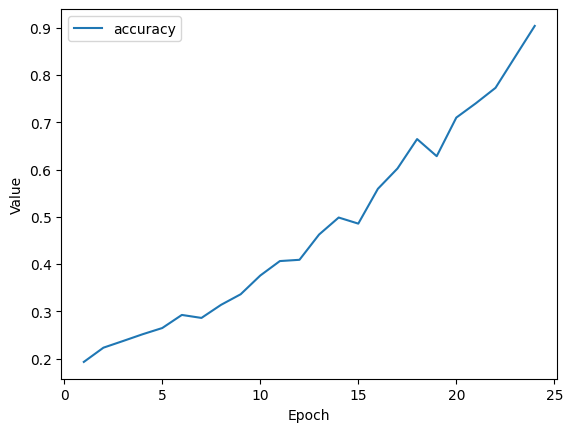

In [85]:
# to plot accuracy
epochs = history.epoch
hist = pd.DataFrame(history.history)
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

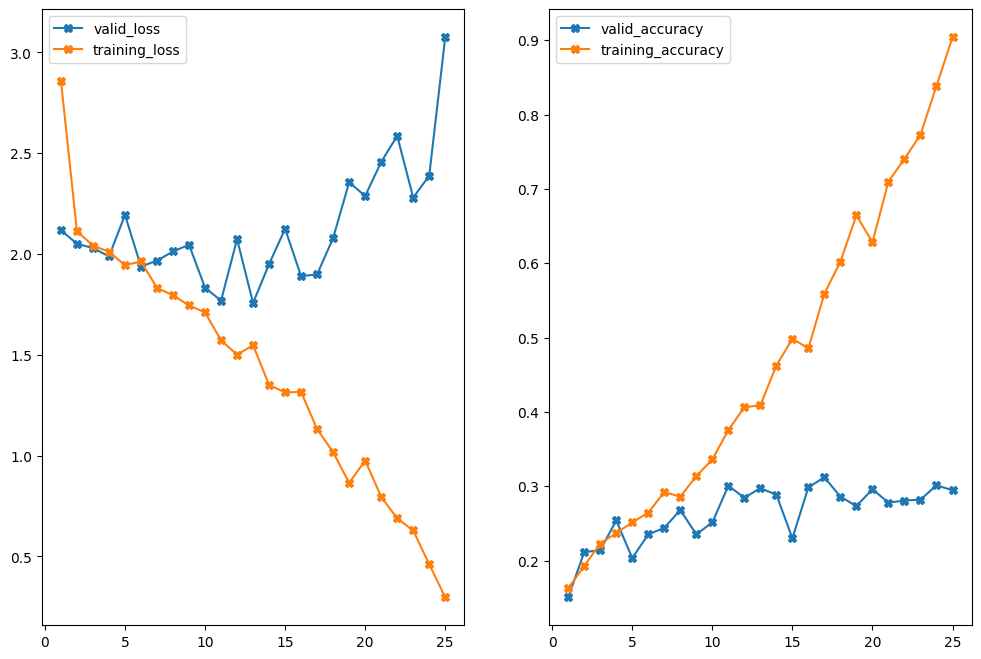

In [86]:
# to ploto training vs validation set
plotting_data_dict = history.history

plt.figure(figsize=(12,8))

valid_loss = plotting_data_dict['val_loss']
training_loss = plotting_data_dict['loss']
valid_accuracy = plotting_data_dict['val_accuracy']
training_accuracy = plotting_data_dict['accuracy']

epochs = range(1,len(valid_loss)+1)

plt.subplot(121)
plt.plot(epochs,valid_loss,marker='X',label='valid_loss')
plt.plot(epochs,training_loss,marker='X',label='training_loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs,valid_accuracy,marker='X',label='valid_accuracy')
plt.plot(epochs,training_accuracy,marker='X',label='training_accuracy')
plt.legend()

In [114]:
# this step should be done on test set
predictions = resnet.predict(x_valid)

 5/47 [==>...........................] - ETA: 16s

KeyboardInterrupt: 

In [113]:
# this step should be done on test set
resnet.evaluate(x=x_valid, y=y_valid_binned)

47/47 [==============================] - 18s 383ms/step - loss: 3.0752 - accuracy: 0.2947


[3.075202465057373, 0.29466667771339417]